In [136]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from cleaning_script import NOMINAL, ORDINAL, CONTINUOUS, DISCRETE, is_outlier

### Read in clean .CSV data

In [137]:
# train
house_train = pd.read_csv('../datasets/house_train_clean.csv')

# test
house_test = pd.read_csv('../datasets/house_test_clean.csv')


### Make DataFrames wide

In [138]:
pd.set_option('display.max_columns', 100)

Modify ORDINAL, NOMINAL, CONTINUOUS and DISCRETE variables based on whatever info we've dropped or kept from the first notebook

In [139]:
ORDINAL = [x for x in ORDINAL if x in house_train.columns]
NOMINAL = [x for x in NOMINAL if x in house_train.columns]
CONTINUOUS = [x for x in CONTINUOUS if x in house_train.columns]
DISCRETE = [x for x in DISCRETE if x in house_train.columns]

# Remove Outliers Based on Z-Score

In [140]:
# remove saleprice outliers 
# house_train = house_train[~is_outlier(house_train.lot_area)];

# consider log-transformation instead
# house_train = house_train[~is_outlier(house_train.saleprice)];


# Plot saleprice with Outliers Removed

<AxesSubplot:ylabel='Frequency'>

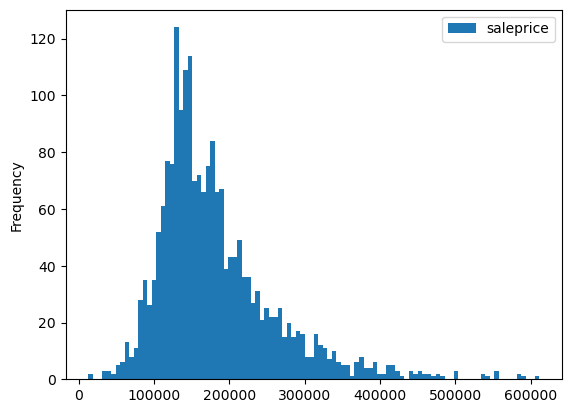

In [141]:
house_train.plot.hist(y='saleprice', bins=100)

# Look for Correlations within Numerical Categories

In [142]:
# create helper function for plotting correlations
corr_vals = {}
def plot_corr_heatmap(CATEGORY, title):
    COLUMNS = [x for x in CATEGORY]
    COLUMNS.append('saleprice')

    fig, ax = plt.subplots(figsize=(12,12))
    corr = house_train[COLUMNS].corr()
    
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.title(f'{title} Correlations')
    return sns.heatmap(corr, mask=mask, annot=True), corr['saleprice']

# dictionary of correlative factors
correlative_factors = {}

### Discrete

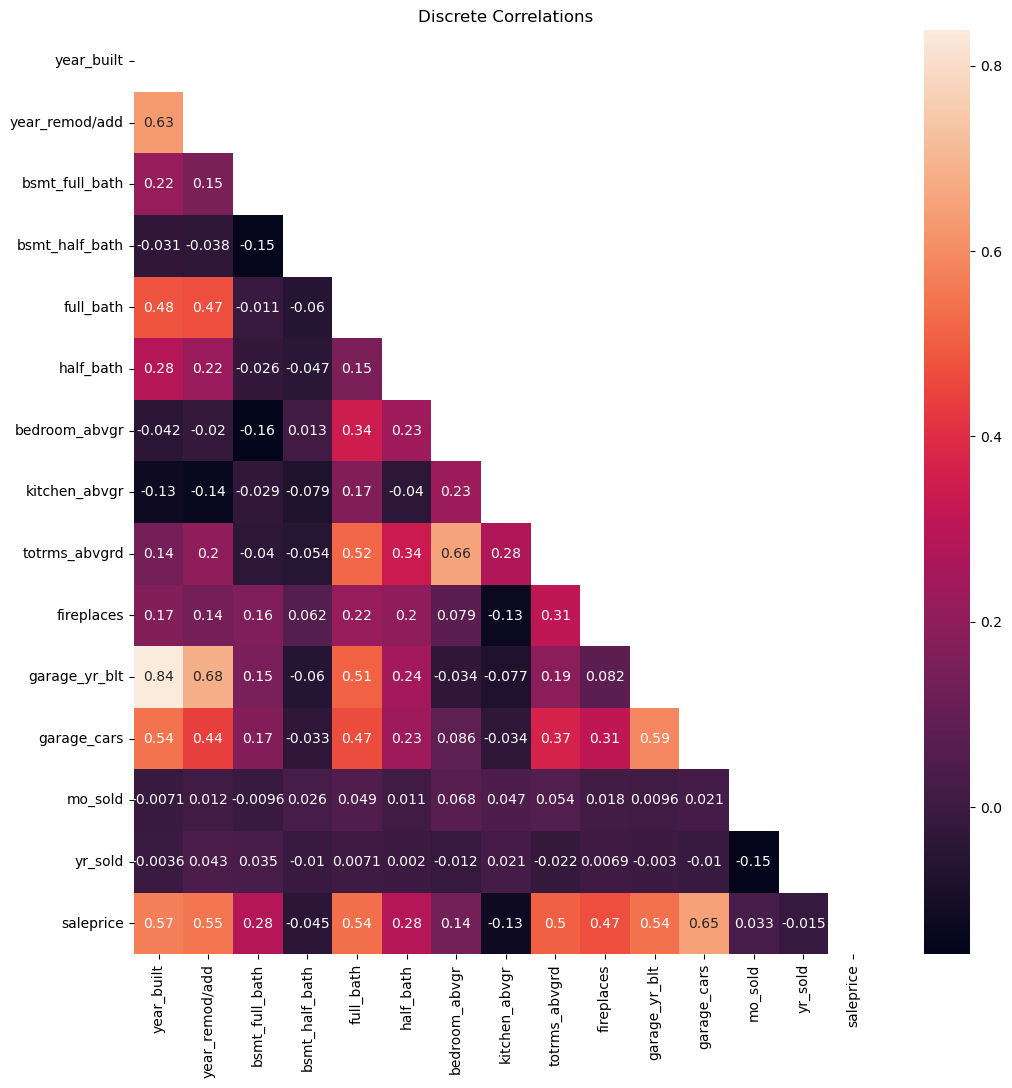

In [143]:
discrete_corrs = plot_corr_heatmap(DISCRETE, 'Discrete')

correlative_factors.update(discrete_corrs[1].to_dict())

### Continous

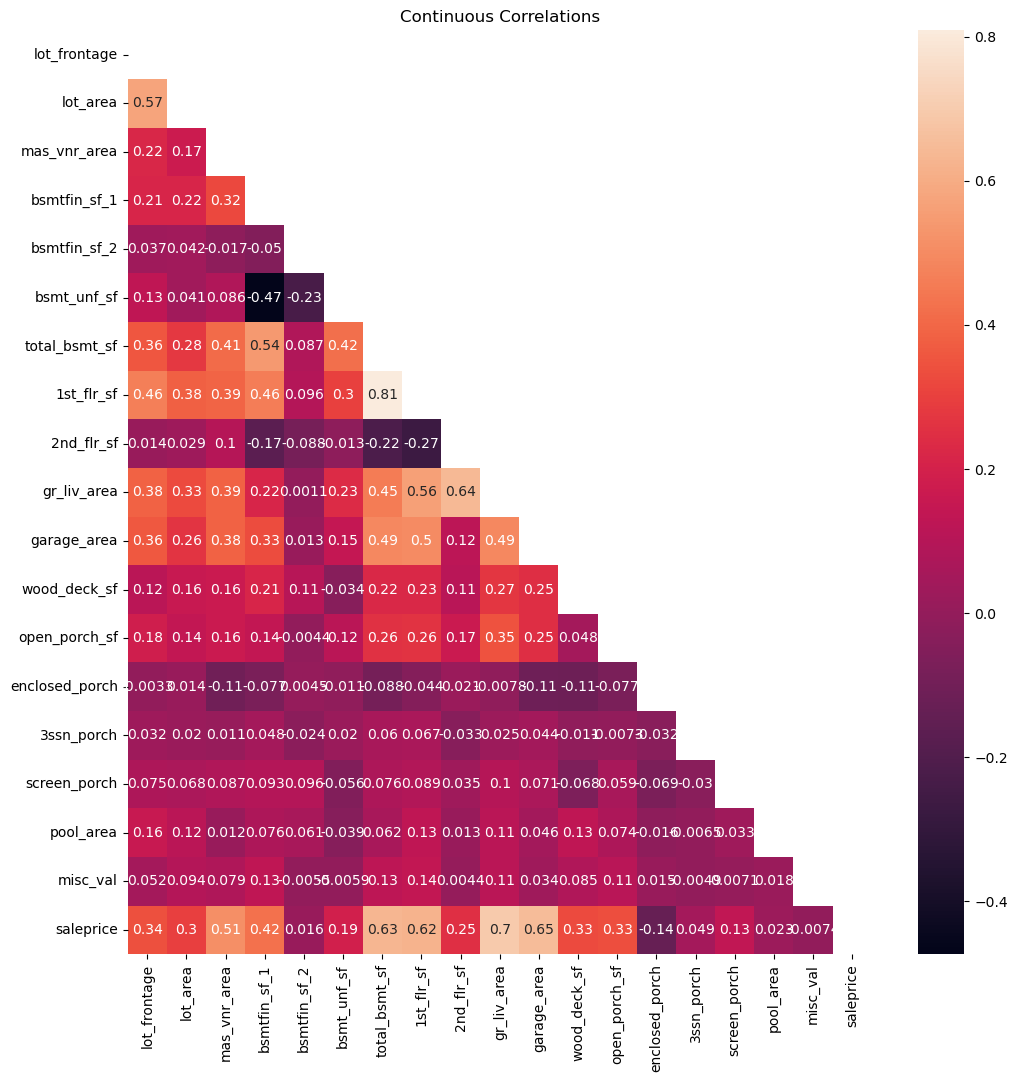

In [144]:
continuous_corrs = plot_corr_heatmap(CONTINUOUS, 'Continuous')

correlative_factors.update(continuous_corrs[1].to_dict())

### Ordinal

Theres clearly a lot of value in these ranked qualitative values, we'll make them numeric and see if we can get some more value. 

       
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

The following columns use this system:  
- exter_qual
- exter_cond
- bsmt_qual
- bsmt_cond
- bsmt_exposure
- heating_qc
- kitchen_qual
- garage_qual
- garage_cond

In [145]:
# functions to rank Ordinal quality ratings
def ordinal_to_numeric_expo(val):
    if val == 'Ex':
        return 4
    elif val == 'Gd':
        return 3
    elif val == 'TA':
        return 2
    elif val == 'Fa':
        return 1
    elif val == 'Po':
        return 0
    else:
        pass

def ordinal_to_numeric_glqna(val):
    if val == 'GLQ':
        return 6
    elif val == 'ALQ':
        return 5
    elif val == 'BLQ':
        return 4
    elif val == 'Rec':
        return 3
    elif val == 'LwQ':
        return 2
    elif val == 'Unf':
        return 1
    elif val == 'NA':
        return 0
    else:
        pass

Find the columns that use the 'Ex - Po' rating schema

In [146]:
rank_words = ['Ex', 'Gd', 'TA','Fa', 'Po']
rank_words = pd.Series(rank_words)
columns_to_fix = []

# find columns, append to columns to fix
for col in house_train[ORDINAL].columns:
    word_check = rank_words.isin(house_train[ORDINAL][col])
    if word_check.sum() > 0:
        columns_to_fix.append(col)
        
# convert columns to numeric values
for col in columns_to_fix:
    house_train[col] = [ordinal_to_numeric_expo(val) for val in house_train[col]]

Basements

In [147]:
basement_cols = ['bsmtfin_type_1', 'bsmtfin_type_2']

for col in basement_cols:
    house_train[col] = [ordinal_to_numeric_glqna(val) for val in house_train[col]]

Ordinal Correlations

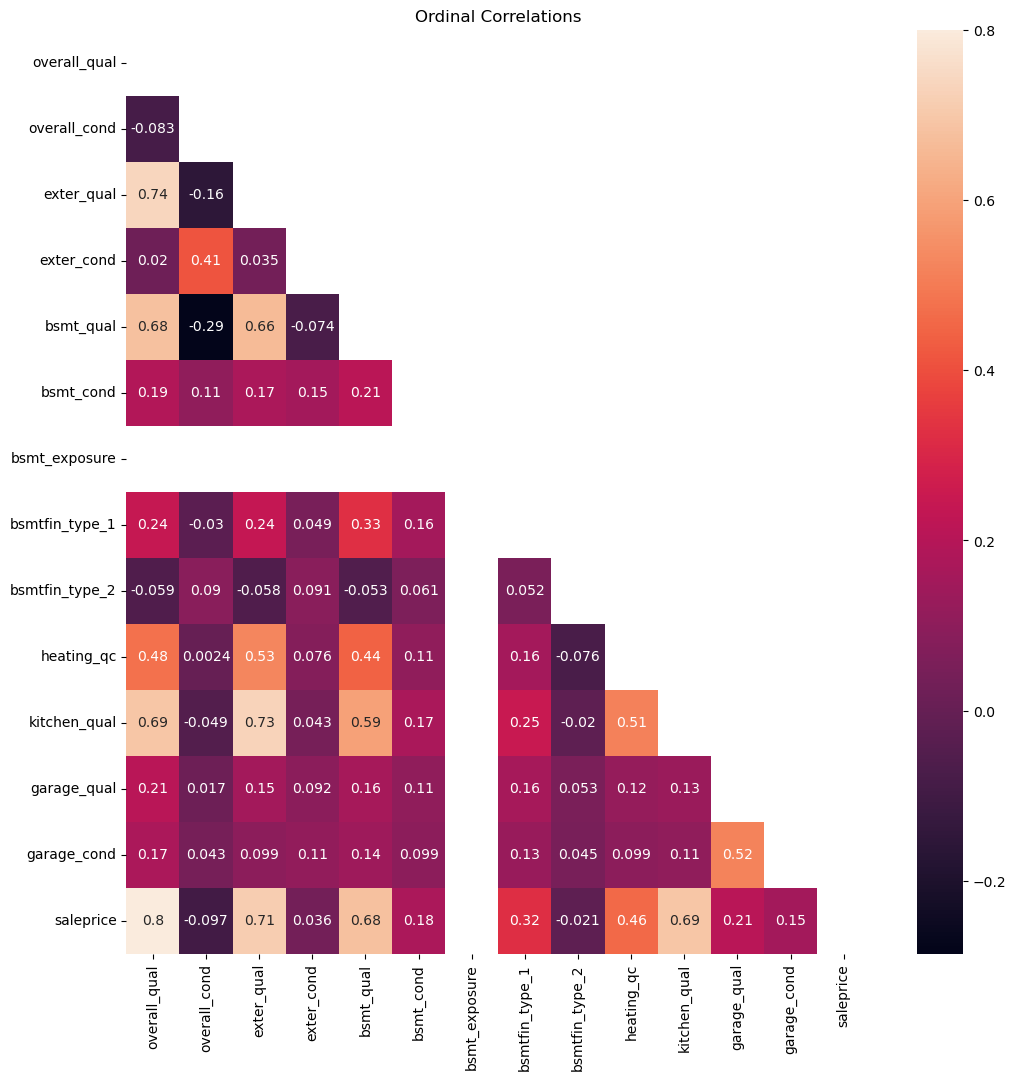

In [148]:
ordinal_corrs = plot_corr_heatmap(ORDINAL, 'Ordinal')

correlative_factors.update(ordinal_corrs[1].to_dict())

### Nominal

Condition 1 (Nominal): Proximity to various conditions
	
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
	
Condition 2 (Nominal): Proximity to various conditions (if more than one is present)
		
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad

These seem important! location, location, location. Let's make them numerical too. 

In [149]:
# get dummies and concat
house_train = pd.concat([house_train, pd.get_dummies(house_train['condition_1'])], axis=1)

# add dummy columns back to NOMINAL so we can call it below
for x in pd.get_dummies(house_train['condition_1']).columns.to_list():
    NOMINAL.append(x)

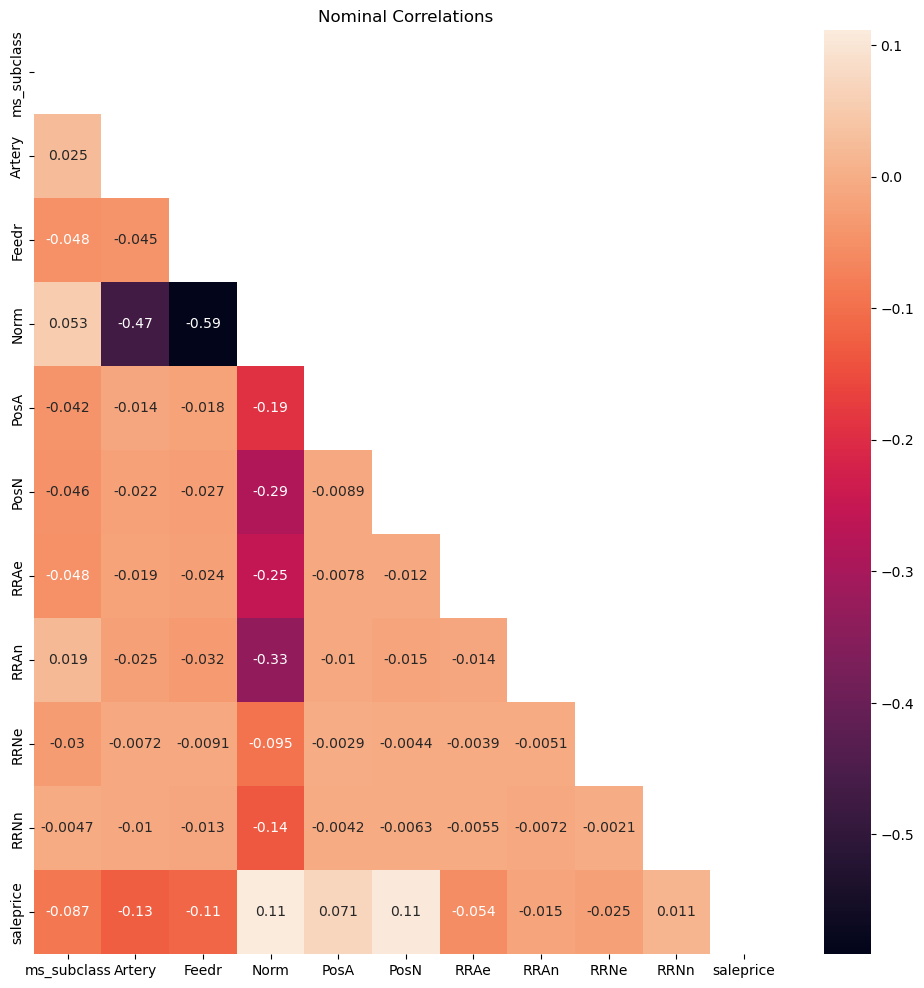

In [150]:
nominal_corrs = plot_corr_heatmap(NOMINAL, 'Nominal')

correlative_factors.update(nominal_corrs[1].to_dict())

'Norm' 'PosA' and 'PosN' have a weak positive correlative effect and being near a railroad or busy thruway has a weak negative correlative effect

# Find Most Correlative Factors
- Gives us a place to start building new features from

In [151]:
correlative_factors = {k:v for k,v in correlative_factors.items() if v > .25}

correlative_factors

{'year_built': 0.5718488959135766,
 'year_remod/add': 0.550369648819556,
 'bsmt_full_bath': 0.28366171790104494,
 'full_bath': 0.5379691021121237,
 'half_bath': 0.28300069798833244,
 'totrms_abvgrd': 0.5040143180735323,
 'fireplaces': 0.47109289376298785,
 'garage_yr_blt': 0.540931494364549,
 'garage_cars': 0.648220264945595,
 'saleprice': 1.0,
 'lot_frontage': 0.34184248372687115,
 'lot_area': 0.2965658323667791,
 'mas_vnr_area': 0.512229843025336,
 'bsmtfin_sf_1': 0.4235188008998825,
 'total_bsmt_sf': 0.628924705734454,
 '1st_flr_sf': 0.6184861410533949,
 'gr_liv_area': 0.6970384443056613,
 'garage_area': 0.6502700352166242,
 'wood_deck_sf': 0.3264897021896556,
 'open_porch_sf': 0.3334760297920542,
 'overall_qual': 0.8002068702531393,
 'exter_qual': 0.7121457238137716,
 'bsmt_qual': 0.6783073466101902,
 'bsmtfin_type_1': 0.32455124062783797,
 'heating_qc': 0.45835416219981734,
 'kitchen_qual': 0.6923363531071017}

# Missing Values for Correlative Factors

In [152]:
missing = house_train[correlative_factors.keys()].isnull().sum()

missing

year_built          0
year_remod/add      0
bsmt_full_bath      2
full_bath           0
half_bath           0
totrms_abvgrd       0
fireplaces          0
garage_yr_blt     114
garage_cars         1
saleprice           0
lot_frontage      330
lot_area            0
mas_vnr_area       22
bsmtfin_sf_1        1
total_bsmt_sf       1
1st_flr_sf          0
gr_liv_area         0
garage_area         1
wood_deck_sf        0
open_porch_sf       0
overall_qual        0
exter_qual          0
bsmt_qual          55
bsmtfin_type_1     55
heating_qc          0
kitchen_qual        0
dtype: int64

`lot_frontage`

<AxesSubplot:title={'center':'After Missing Values Filled'}, ylabel='Frequency'>

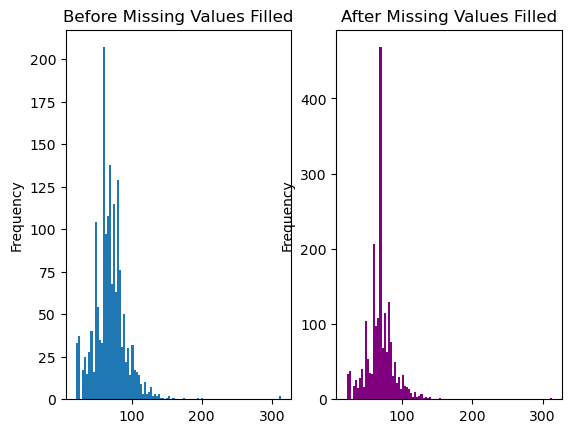

In [153]:
before = house_train['lot_frontage'].copy()
# median is 67, mean is 68, fill with mean
house_train['lot_frontage'].fillna(house_train['lot_frontage'].mean(), inplace = True)

fig, axes = plt.subplots(1,2)

before.plot.hist(bins=100, ax = axes[0], title='Before Missing Values Filled')
house_train['lot_frontage'].plot.hist(bins=100, ax = axes[1], color = 'purple', title = 'After Missing Values Filled')

`mas_vnr_area`

<AxesSubplot:title={'center':'After Missing Values Filled'}, ylabel='Frequency'>

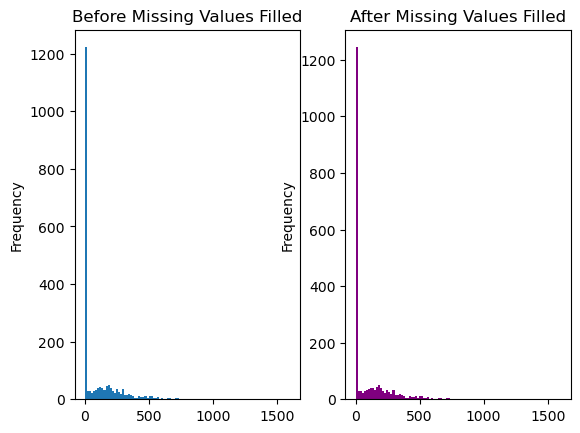

In [154]:
before = house_train['mas_vnr_area'].copy()

house_train['mas_vnr_area'].fillna(0, inplace=True) # 0 is the mode, overwhelmingly the case

fig, axes = plt.subplots(1,2)

before.plot.hist(bins=100, ax = axes[0], title='Before Missing Values Filled')
house_train['mas_vnr_area'].plot.hist(bins=100, ax = axes[1], color = 'purple', title = 'After Missing Values Filled')

`bsmtfin_type_1`

In [155]:
len(house_train.query('bsmtfin_type_1 == 1 and bsmtfin_type_1.notna()'))
len(house_train.query('bsmtfin_type_1.notna()'))


1996

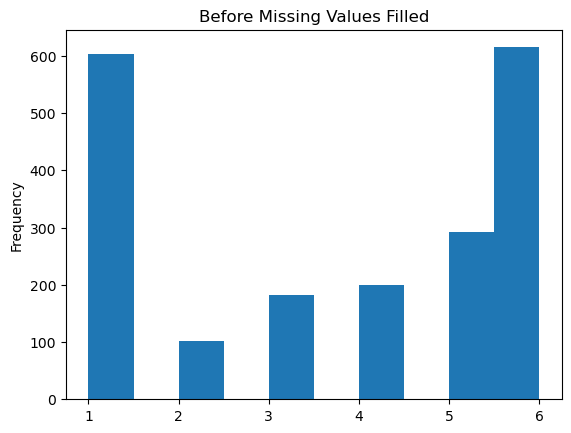

In [156]:
before = house_train['bsmtfin_type_1'].plot.hist(title='Before Missing Values Filled')
weights = []
# find distribution of scores amongst the values have aren't NaN, append proportions to weights
for x in range(1,7):
    weights.append(
    len(house_train.query(f'bsmtfin_type_1 == {x} and bsmtfin_type_1.notna()'))/
    len(house_train.query(f'bsmtfin_type_1.notna()'))
    )

# use proportions as probability weights for random assignment of values
house_train['bsmtfin_type_1'].fillna(np.random.choice(np.arange(1,7), p=weights), inplace=True)

`bsmt_full_bath`

In [157]:
house_train.bsmt_full_bath.describe()

count    2049.000000
mean        0.427526
std         0.522673
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         3.000000
Name: bsmt_full_bath, dtype: float64

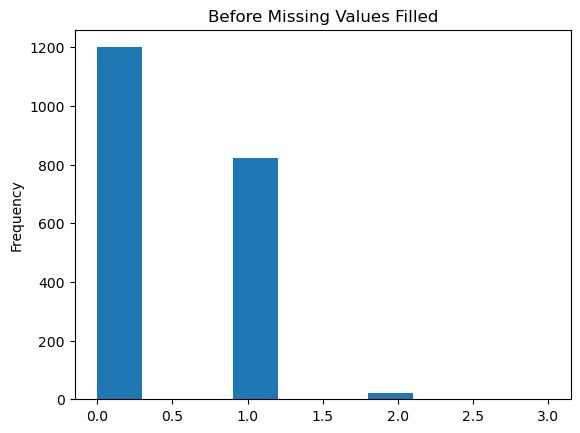

In [158]:
house_train.bsmt_full_bath.plot.hist(title = 'Before Missing Values Filled')

weights = []
# find distribution of scores amongst the values have aren't NaN, append proportions to weights
for x in range(0,3):
    weights.append(
    len(house_train.query(f'bsmt_full_bath == {x} and bsmt_full_bath.notna()'))/
    len(house_train.query(f'bsmt_full_bath.notna()'))
    )

# normalize so numpy doesn't flag .9998 as not being 1.0
weights = np.array(weights)
weights /= weights.sum()

# use proportions as probability weights for random assignment of values
house_train['bsmt_full_bath'].fillna(np.random.choice(np.arange(0,3), p=weights), inplace=True)



`bsmtfin_sf_1`

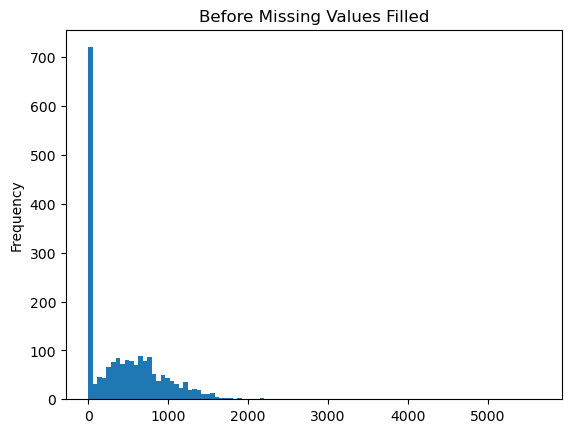

In [159]:
house_train.bsmtfin_sf_1.plot.hist(title='Before Missing Values Filled', bins=100)

house_train['bsmtfin_sf_1'].fillna(0, inplace=True) # 0 is the mode, overwhelmingly the case

`garage_yr_blt`

0    2005.0
Name: garage_yr_blt, dtype: float64


<AxesSubplot:title={'center':'After Missing Values Filled'}, ylabel='Frequency'>

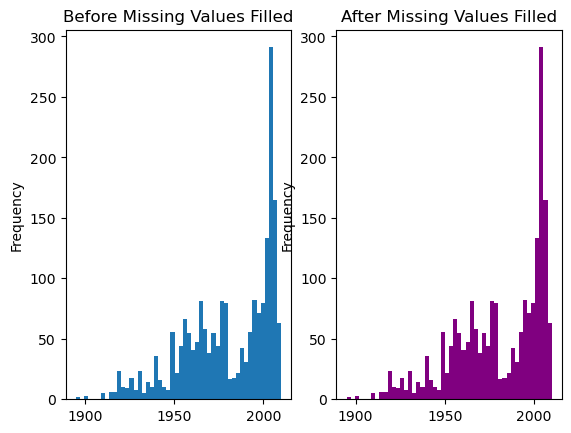

In [160]:

before = house_train['garage_yr_blt']

print(house_train.garage_yr_blt.mode())
# the mean and median for garage_yr_built are all 1978, the mode is 2005
house_train['garage_yr_blt'].fillna(2005, inplace=True)

fig, axes = plt.subplots(1,2)

before.plot.hist(bins=50, ax = axes[0], title='Before Missing Values Filled')
house_train['garage_yr_blt'].plot.hist(bins=50, ax = axes[1], color = 'purple', title = 'After Missing Values Filled')

`bsmt_qual`

<AxesSubplot:title={'center':'After Missing Values Filled'}, ylabel='Frequency'>

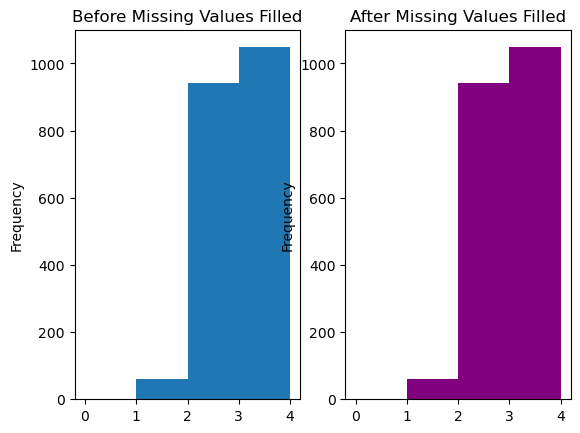

In [161]:
before = house_train['bsmt_qual'] # mode is 2, median is 3, mean is 2.5
house_train['bsmt_qual'].fillna(house_train.bsmt_qual.mean(), inplace=True)

fix, axes = plt.subplots(1, 2)
before.plot.hist(bins=4, ax = axes[0], title='Before Missing Values Filled')
house_train['bsmt_qual'].plot.hist(bins=4, ax = axes[1], color = 'purple', title = 'After Missing Values Filled')

`garage_area` and `garage_cars`

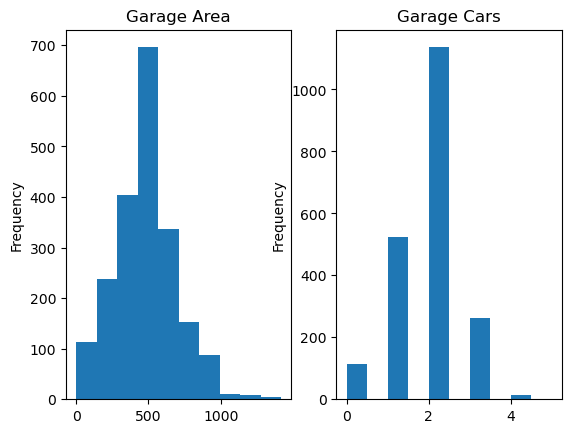

In [162]:
# both of these are just missing 1 value and are close to normally distributed, so we'll insert the median..

fix, axes = plt.subplots(1,2)
house_train.garage_area.plot.hist(title='Garage Area', ax=axes[0])
house_train.garage_cars.plot.hist(title='Garage Cars', ax=axes[1])

for col in ['garage_cars', 'garage_area']:
    house_train[col].fillna(house_train[col].median(), inplace=True)

`total_bsmt_sqft`

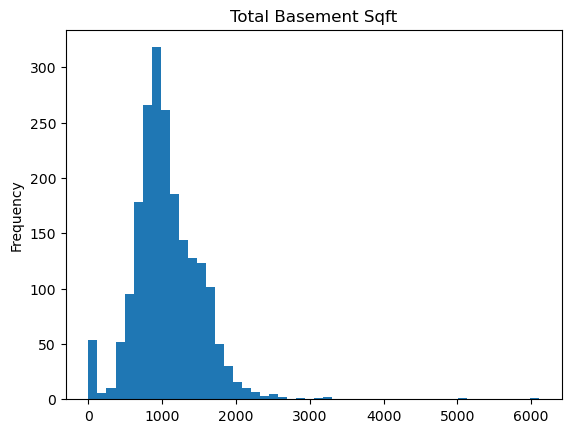

In [163]:
house_train['total_bsmt_sf'].plot.hist(bins=50, title= 'Total Basement Sqft')

house_train['total_bsmt_sf'].fillna(house_train['total_bsmt_sf'].mean(), inplace=True)

In [164]:
house_train[correlative_factors.keys()].isnull().sum()

year_built        0
year_remod/add    0
bsmt_full_bath    0
full_bath         0
half_bath         0
totrms_abvgrd     0
fireplaces        0
garage_yr_blt     0
garage_cars       0
saleprice         0
lot_frontage      0
lot_area          0
mas_vnr_area      0
bsmtfin_sf_1      0
total_bsmt_sf     0
1st_flr_sf        0
gr_liv_area       0
garage_area       0
wood_deck_sf      0
open_porch_sf     0
overall_qual      0
exter_qual        0
bsmt_qual         0
bsmtfin_type_1    0
heating_qc        0
kitchen_qual      0
dtype: int64

In [165]:
del correlative_factors['saleprice']

house_test[correlative_factors.keys()].isnull().sum()

year_built          0
year_remod/add      0
bsmt_full_bath      0
full_bath           0
half_bath           0
totrms_abvgrd       0
fireplaces          0
garage_yr_blt      45
garage_cars         0
lot_frontage      160
lot_area            0
mas_vnr_area        1
bsmtfin_sf_1        0
total_bsmt_sf       0
1st_flr_sf          0
gr_liv_area         0
garage_area         0
wood_deck_sf        0
open_porch_sf       0
overall_qual        0
exter_qual          0
bsmt_qual          25
bsmtfin_type_1     25
heating_qc          0
kitchen_qual        0
dtype: int64

# Feature Engineering

### Neighborhood Group

In [166]:
group_by_neighborhood = house_train.groupby('neighborhood')['saleprice'].median().sort_values(ascending=False)

neighbor_hood_dict = {}
for i, val in enumerate(group_by_neighborhood):
    neighbor_hood_dict.update({group_by_neighborhood.index[i]:i})

house_train['neighborhood_price_rank'] = [neighbor_hood_dict[neighborhood] for neighborhood in house_train.neighborhood]

In [167]:
# .73, nice!
neighborhood_corr = house_train[['neighborhood_price_rank', 'saleprice']].corr()

correlative_factors.update(neighborhood_corr['saleprice'].to_dict())

### Age of Home

In [168]:
house_train['house_age'] = house_train['yr_sold'] - house_train['year_built']

In [169]:
# .60
age_corr = house_train[['house_age', 'saleprice']].corr()

correlative_factors.update(age_corr['saleprice'].to_dict())

### Age of Garage

In [170]:
house_train['garage_age'] = house_train['yr_sold'] - house_train['garage_yr_blt'] 
garage_corr = house_train[['garage_age', 'saleprice']].corr()

correlative_factors.update(age_corr['saleprice'].to_dict())

In [171]:
# house_train.plot.scatter(x='total_bsmt_sf', y='saleprice')

### Bubble Burst

In [172]:
meltdown_list = []
for idx, row in house_train.iterrows():
    if row['sale_type'] == 'New' and row['house_age'] < 3:
        meltdown_list.append(1)
    else:
        meltdown_list.append(0)

house_train['meltdown'] = meltdown_list


meltdown_corr = house_train[['meltdown', 'saleprice']].corr()

meltdown_corr
# correlative_factors.update(neighborhood_corr['saleprice'].to_dict())

,meltdown,saleprice
meltdown,1.000000,0.358245
saleprice,0.358245,1.000000


Sanity check
- quick LinReg to see how we're moving along

In [173]:
correlative_factors

{'year_built': 0.5718488959135766,
 'year_remod/add': 0.550369648819556,
 'bsmt_full_bath': 0.28366171790104494,
 'full_bath': 0.5379691021121237,
 'half_bath': 0.28300069798833244,
 'totrms_abvgrd': 0.5040143180735323,
 'fireplaces': 0.47109289376298785,
 'garage_yr_blt': 0.540931494364549,
 'garage_cars': 0.648220264945595,
 'lot_frontage': 0.34184248372687115,
 'lot_area': 0.2965658323667791,
 'mas_vnr_area': 0.512229843025336,
 'bsmtfin_sf_1': 0.4235188008998825,
 'total_bsmt_sf': 0.628924705734454,
 '1st_flr_sf': 0.6184861410533949,
 'gr_liv_area': 0.6970384443056613,
 'garage_area': 0.6502700352166242,
 'wood_deck_sf': 0.3264897021896556,
 'open_porch_sf': 0.3334760297920542,
 'overall_qual': 0.8002068702531393,
 'exter_qual': 0.7121457238137716,
 'bsmt_qual': 0.6783073466101902,
 'bsmtfin_type_1': 0.32455124062783797,
 'heating_qc': 0.45835416219981734,
 'kitchen_qual': 0.6923363531071017,
 'neighborhood_price_rank': -0.7207224797299524,
 'saleprice': 1.0,
 'house_age': -0.57188

In [174]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, KFold, cross_val_score


X = house_train[[x for x in correlative_factors.keys() if x not in ['saleprice', 'garage_yr_blt', 'year_built', 'year_remod/add',
                                                                    'gr_liv_area']]]
y = house_train.saleprice

X_train, X_test, y_train, y_test = train_test_split(X, y)


X_train.isnull().sum()

mlr = LinearRegression()
# train it

X_train.isnull().sum()
scores_1 = (cross_val_score(LinearRegression(), X_train, y_train, cv = KFold(n_splits=5,
                                                                 shuffle=True,
                                                                 random_state=42)))
# cross val score
scores_1.mean()



0.845602824004329

In [175]:
#calculate residuals by creating predictions
mlr.fit(X_train,y_train)
preds = mlr.predict(X_train)
resid = y_train - preds

In [176]:
mlr.score(X_test, y_test)

0.7650881418802231

Text(0.5, 1.0, 'Predicted vs. Actual')

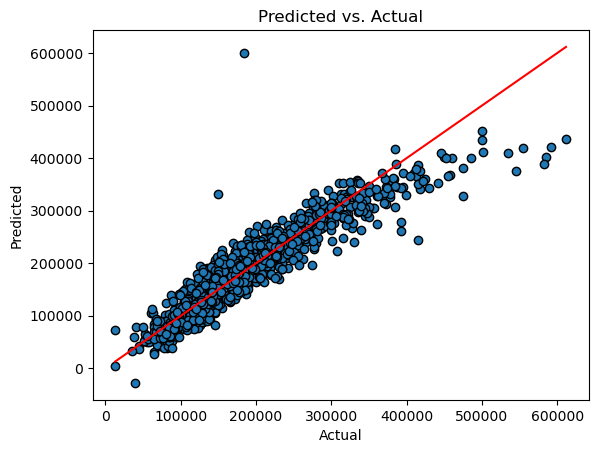

In [177]:
fig, ax = plt.subplots()
ax.scatter(y_train, preds, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],'r')

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('Predicted vs. Actual')

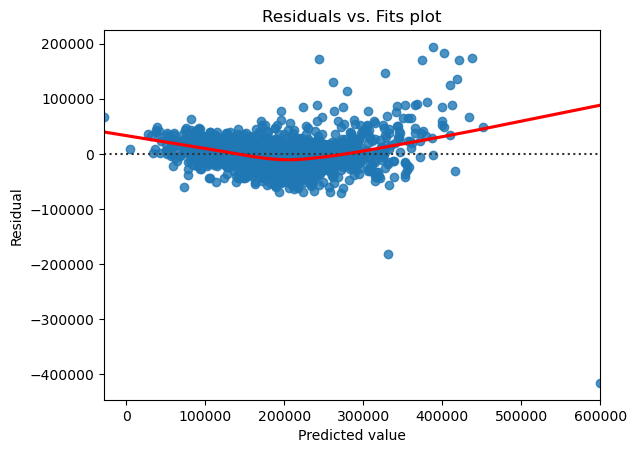

In [178]:


sns.residplot(x = preds,
              y = resid,
              lowess = True, #help visualize relationship
              line_kws = {'color' : 'red'})\
    .set(title = 'Residuals vs. Fits plot',
        xlabel = 'Predicted value',
        ylabel = 'Residual'); #change lowess color

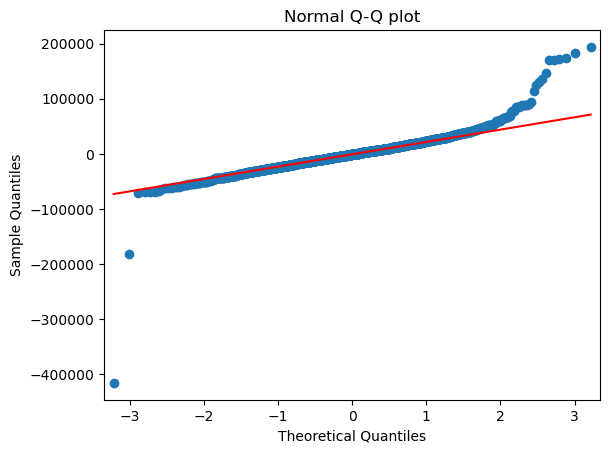

In [179]:

sm.qqplot(resid,
         dist = stats.norm,
         line = 'q')

plt.title('Normal Q-Q plot');

In [180]:
import statsmodels.api as sm

X_sm = sm.add_constant(X_test)

res = sm.OLS(y_test,X_sm).fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     99.55
Date:                Fri, 02 Dec 2022   Prob (F-statistic):          5.57e-168
Time:                        21:41:48   Log-Likelihood:                -6052.8
No. Observations:                 513   AIC:                         1.215e+04
Df Residuals:                     489   BIC:                         1.226e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -8.098e+04   1.74e+04     -4.647      0.000   -1.15e+05   -4.67e+04
bsmt_full_bath           3149.4481   3848.679      0.818      0.414   -4412.541    1.07e+04
full_bath                1636.6331   4023.445      0.407      0.684   -6268.741    9542.007
half_bath                5119.0884   3872.660      1.322      0.187   -2490.019    1.27e+04
totrms_abvgrd            6118.8328   1384.960      4.418      0.000    3397.626    8840.040
fireplaces               2460.5825   2749.031      0.895      0.371   -2940.787    7861.953
garage_cars              1.965e+04   5078.247      3.870      0.000    9676.112    2.96e+04
lot_frontage             -165.6357     89.943     -1.842      0.066    -342.357      11.086
lot_area                    1.0098      0.336      3.002      0.003       0.349       1.671
mas_vnr_area               37.7731      9.686      3.900      0.000      18.741      56.805
bsmtfin_sf_1               -0.0479      5.750     -0.008      0.993     -11.347      11.251
total_bsmt_sf              -6.4507      6.834     -0.944      0.346     -19.878       6.977
1st_flr_sf                 29.9077      8.085      3.699      0.000      14.023      45.793
garage_area               -31.7185     17.796     -1.782      0.075     -66.685       3.248
wood_deck_sf               34.3709     12.250      2.806      0.005      10.301      58.441
open_porch_sf              44.3796     22.970      1.932      0.054      -0.752      89.511
overall_qual             1.392e+04   2100.992      6.624      0.000    9788.725     1.8e+04
exter_qual               8991.3425   4444.617      2.023      0.044     258.439    1.77e+04
bsmt_qual                8499.3292   3557.680      2.389      0.017    1509.103    1.55e+04
bsmtfin_type_1           3470.7456   1087.405      3.192      0.002    1334.182    5607.309
heating_qc               4898.8535   1901.877      2.576      0.010    1161.994    8635.712
kitchen_qual             9875.2725   3563.176      2.771      0.006    2874.249    1.69e+04
neighborhood_price_rank -2505.9019    344.905     -7.265      0.000   -3183.581   -1828.223
house_age                 395.6643     91.330      4.332      0.000     216.217     575.111
==============================================================================
Omnibus:                      104.086   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2138.682
Skew:                           0.163   Prob(JB):                         0.00
Kurtosis:                      12.997   Cond. No.                     1.41e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number 

In [181]:
X_test

,bsmt_full_bath,full_bath,half_bath,totrms_abvgrd,fireplaces,garage_cars,lot_frontage,lot_area,mas_vnr_area,bsmtfin_sf_1,total_bsmt_sf,1st_flr_sf,garage_area,wood_deck_sf,open_porch_sf,overall_qual,exter_qual,bsmt_qual,bsmtfin_type_1,heating_qc,kitchen_qual,neighborhood_price_rank,house_age
1903,0.0,2,1,7,1,2.0,80.0000,12435,172.0,361.0,963.0,963,564.0,0,96,7,3,3.0,6.0,4,3,8,7
525,1.0,1,0,7,0,1.0,58.0000,9280,0.0,557.0,1342.0,1342,256.0,0,0,5,2,1.0,5.0,4,2,23,56
333,0.0,2,0,10,0,2.0,69.0552,11888,0.0,0.0,844.0,1445,441.0,0,60,6,2,2.0,1.0,3,3,22,93
2008,0.0,2,0,8,0,2.0,69.0552,11500,164.0,0.0,1680.0,1680,528.0,0,0,5,2,2.0,1.0,1,2,12,31
158,1.0,1,0,6,0,2.0,60.0000,9873,160.0,789.0,960.0,960,576.0,0,288,4,2,2.0,5.0,2,2,22,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0.0,1,0,6,0,1.0,70.0000,8750,0.0,172.0,1382.0,1382,350.0,280,0,5,2,2.0,3.0,3,3,17,54
1364,0.0,2,1,6,0,2.0,63.0000,11426,0.0,0.0,1362.0,1362,484.0,280,238,7,2,3.0,1.0,4,3,24,5
639,0.0,1,1,8,2,2.0,69.0552,15660,312.0,341.0,798.0,1137,431.0,0,119,7,3,2.0,4.0,4,3,9,69
1266,1.0,2,1,7,1,2.0,90.0000,11367,210.0,932.0,1065.0,1091,586.0,199,60,8,3,3.0,6.0,4,3,8,4


In [182]:
# house_test = pd.read_csv('../datasets/test.csv')

# X = house_test[[x for x in correlative_factors.keys() if x not in ['saleprice', 'garage_yr_blt', 'year_built', 'year_remod/add',
#                                                                     'gr_liv_area']]]

